# Pairs trading

In [1]:
from vectorbtpro import *
# whats_imported()

vbt.settings.set_theme("dark")

## Selection

In [2]:
SYMBOLS = vbt.BinanceData.list_symbols("*USDT")
POOL_FILE = "temp/data_pool.h5"
START = "2018"
END = "2023"

# vbt.remove_dir("temp", with_contents=True, missing_ok=True)
vbt.make_dir("temp")

if not vbt.file_exists(POOL_FILE):
    with vbt.ProgressBar(total=len(SYMBOLS)) as pbar:
        collected = 0
        for symbol in SYMBOLS:
            try:
                data = vbt.BinanceData.pull(
                    symbol, 
                    start=START,
                    end=END,
                    show_progress=False,
                    silence_warnings=True
                )
                data.to_hdf(POOL_FILE)
                collected += 1
            except Exception:
                pass
            pbar.set_prefix(f"{symbol} ({collected})")
            pbar.update()

In [3]:
SELECT_START = "2020"
SELECT_END = "2021"

data = vbt.HDFData.pull(
    POOL_FILE, 
    start=SELECT_START, 
    end=SELECT_END, 
    silence_warnings=True
)

print(len(data.symbols))

  0%|          | 0/418 [00:00<?, ?it/s]

245


In [4]:
data = data.select([
    k 
    for k, v in data.data.items() 
    if not v.isnull().any().any()
])

print(len(data.symbols))

82


In [5]:
@vbt.parameterized(
    merge_func="concat", 
    engine="pathos",
    distribute="chunks",
    n_chunks="auto"
)
def coint_pvalue(close, s1, s2):
    import statsmodels.tsa.stattools as ts
    import numpy as np
    return ts.coint(np.log(close[s1]), np.log(close[s2]))[1]

COINT_FILE = "temp/coint_pvalues.pickle"

# vbt.remove_file(COINT_FILE, missing_ok=True)
if not vbt.file_exists(COINT_FILE):
    coint_pvalues = coint_pvalue(
        data.close,
        vbt.Param(data.symbols, condition="s1 != s2"),
        vbt.Param(data.symbols)
    )
    vbt.save(coint_pvalues, COINT_FILE)
else:
    coint_pvalues = vbt.load(COINT_FILE)

In [6]:
coint_pvalues = coint_pvalues.sort_values()

print(coint_pvalues)

s1        s2      
TUSDUSDT  BUSDUSDT    6.179128e-17
USDCUSDT  BUSDUSDT    7.703666e-14
BUSDUSDT  USDCUSDT    2.687508e-13
TUSDUSDT  USDCUSDT    2.906244e-12
BUSDUSDT  TUSDUSDT    1.853641e-11
                          ...     
BTCUSDT   XTZUSDT     1.000000e+00
          EOSUSDT     1.000000e+00
          ENJUSDT     1.000000e+00
          NKNUSDT     1.000000e+00
ZILUSDT   HBARUSDT    1.000000e+00
Length: 6642, dtype: float64


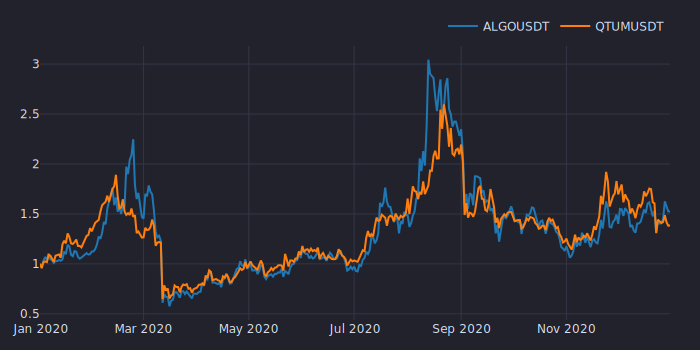

In [7]:
S1, S2 = "ALGOUSDT", "QTUMUSDT"

data.plot(column="Close", symbol=[S1, S2], base=1).show_svg()

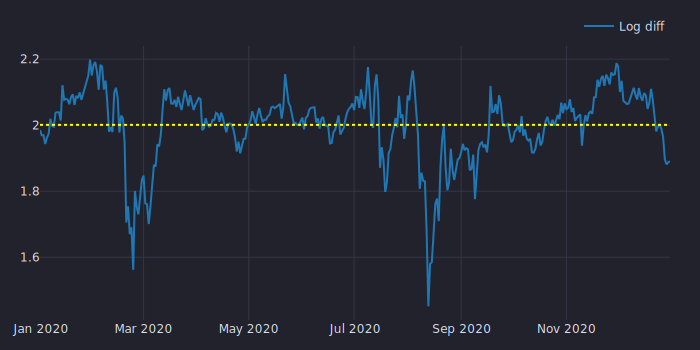

In [8]:
S1_log = np.log(data.get("Close", S1))
S2_log = np.log(data.get("Close", S2))
log_diff = (S2_log - S1_log).rename("Log diff")
fig = log_diff.vbt.plot()
fig.add_hline(y=log_diff.mean(), line_color="yellow", line_dash="dot")
fig.show_svg()

## Testing

In [9]:
DATA_FILE = "temp/data.pickle"

# vbt.remove_file(DATA_FILE, missing_ok=True)
if not vbt.file_exists(DATA_FILE):
    data = vbt.BinanceData.pull(
        [S1, S2], 
        start=SELECT_END,
        end=END, 
        timeframe="hourly"
    )
    vbt.save(data, DATA_FILE)
else:
    data = vbt.load(DATA_FILE)

print(len(data.index))

17507


### Level: Researcher

In [10]:
import scipy.stats as st

WINDOW = 24 * 30
UPPER = st.norm.ppf(1 - 0.05 / 2)
LOWER = -st.norm.ppf(1 - 0.05 / 2)

S1_close = data.get("Close", S1)
S2_close = data.get("Close", S2)
ols = vbt.OLS.run(S1_close, S2_close, window=vbt.Default(WINDOW))
spread = ols.error.rename("Spread")
zscore = ols.zscore.rename("Z-score")
print(pd.concat((spread, zscore), axis=1))

                             Spread   Z-score
Open time                                    
2021-01-01 00:00:00+00:00       NaN       NaN
2021-01-01 01:00:00+00:00       NaN       NaN
2021-01-01 02:00:00+00:00       NaN       NaN
2021-01-01 03:00:00+00:00       NaN       NaN
2021-01-01 04:00:00+00:00       NaN       NaN
...                             ...       ...
2022-12-31 19:00:00+00:00 -0.121450 -1.066809
2022-12-31 20:00:00+00:00 -0.123244 -1.078957
2022-12-31 21:00:00+00:00 -0.122595 -1.070667
2022-12-31 22:00:00+00:00 -0.125066 -1.088617
2022-12-31 23:00:00+00:00 -0.130532 -1.131498

[17507 rows x 2 columns]


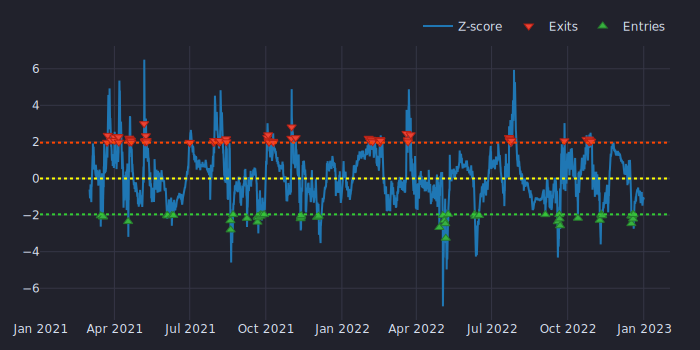

In [11]:
upper_crossed = zscore.vbt.crossed_above(UPPER)
lower_crossed = zscore.vbt.crossed_below(LOWER)

fig = zscore.vbt.plot()
fig.add_hline(y=UPPER, line_color="orangered", line_dash="dot")
fig.add_hline(y=0, line_color="yellow", line_dash="dot")
fig.add_hline(y=LOWER, line_color="limegreen", line_dash="dot")
upper_crossed.vbt.signals.plot_as_exits(zscore, fig=fig)
lower_crossed.vbt.signals.plot_as_entries(zscore, fig=fig)
fig.show_svg()

In [12]:
long_entries = data.symbol_wrapper.fill(False)
short_entries = data.symbol_wrapper.fill(False)

short_entries.loc[upper_crossed, S1] = True
long_entries.loc[upper_crossed, S2] = True
long_entries.loc[lower_crossed, S1] = True
short_entries.loc[lower_crossed, S2] = True

print(long_entries.sum())
print(short_entries.sum())

symbol
ALGOUSDT    52
QTUMUSDT    73
dtype: int64
symbol
ALGOUSDT    73
QTUMUSDT    52
dtype: int64


In [13]:
pf = vbt.Portfolio.from_signals(
    data,
    entries=long_entries,
    short_entries=short_entries,
    size=10,
    size_type="valuepercent100",
    group_by=True,
    cash_sharing=True,
    call_seq="auto"
)

In [14]:
fig = pf.plot_allocations()
rebalancing_dates = data.index[np.unique(pf.orders.idx.values)]
for date in rebalancing_dates:
    fig.add_vline(x=date, line_color="teal", line_dash="dot")
fig.show_svg()

In [15]:
pf.stats()

Start                          2021-01-01 00:00:00+00:00
End                            2022-12-31 23:00:00+00:00
Period                                 729 days 11:00:00
Start Value                                        100.0
Min Value                                      96.401924
Max Value                                     127.670782
End Value                                     119.930329
Total Return [%]                               19.930329
Benchmark Return [%]                          -34.051206
Total Time Exposure [%]                        89.946878
Max Gross Exposure [%]                         37.103161
Max Drawdown [%]                                8.592299
Max Drawdown Duration                  318 days 00:00:00
Total Orders                                          34
Total Fees Paid                                      0.0
Total Trades                                          34
Win Rate [%]                                       43.75
Best Trade [%]                 

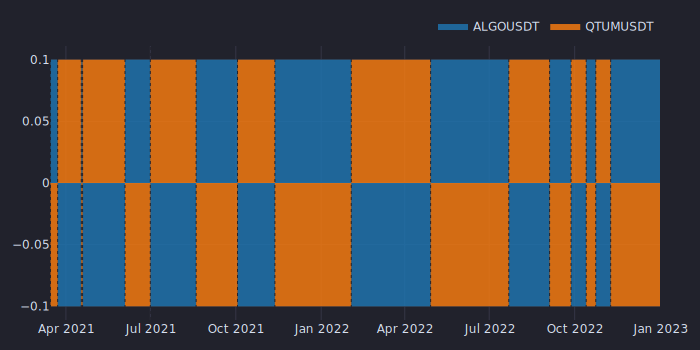

In [16]:
allocations = data.symbol_wrapper.fill()
allocations.loc[upper_crossed, S1] = -0.1
allocations.loc[upper_crossed, S2] = 0.1
allocations.loc[lower_crossed, S1] = 0.1
allocations.loc[lower_crossed, S2] = -0.1
pfo = vbt.PortfolioOptimizer.from_filled_allocations(allocations)
pfo.plot().show_svg()

In [17]:
print(pfo.allocations)

symbol                     ALGOUSDT  QTUMUSDT
Open time                                    
2021-03-15 10:00:00+00:00       0.1      -0.1
2021-03-23 03:00:00+00:00      -0.1       0.1
2021-04-17 14:00:00+00:00       0.1      -0.1
2021-04-19 00:00:00+00:00      -0.1       0.1
2021-06-03 16:00:00+00:00       0.1      -0.1
2021-06-30 22:00:00+00:00      -0.1       0.1
2021-08-19 06:00:00+00:00       0.1      -0.1
2021-10-02 21:00:00+00:00      -0.1       0.1
2021-11-12 03:00:00+00:00       0.1      -0.1
2022-02-02 09:00:00+00:00      -0.1       0.1
2022-04-28 21:00:00+00:00       0.1      -0.1
2022-07-22 02:00:00+00:00      -0.1       0.1
2022-09-04 01:00:00+00:00       0.1      -0.1
2022-09-27 03:00:00+00:00      -0.1       0.1
2022-10-13 10:00:00+00:00       0.1      -0.1
2022-10-23 19:00:00+00:00      -0.1       0.1
2022-11-08 20:00:00+00:00       0.1      -0.1


In [18]:
pf = pfo.simulate(data, pf_method="from_signals")
pf.total_return

0.19930328736504038

In [19]:
PTS_expr = """
    PTS:
    x = @in_close.iloc[:, 0]
    y = @in_close.iloc[:, 1]
    ols = vbt.OLS.run(x, y, window=@p_window, hide_params=True)
    upper = st.norm.ppf(1 - @p_upper_alpha / 2)
    lower = -st.norm.ppf(1 - @p_lower_alpha / 2)
    upper_crossed = ols.zscore.vbt.crossed_above(upper)
    lower_crossed = ols.zscore.vbt.crossed_below(lower)
    long_entries = wrapper.fill(False)
    short_entries = wrapper.fill(False)
    short_entries.loc[upper_crossed, x.name] = True
    long_entries.loc[upper_crossed, y.name] = True
    long_entries.loc[lower_crossed, x.name] = True
    short_entries.loc[lower_crossed, y.name] = True
    long_entries, short_entries
"""

PTS = vbt.IF.from_expr(PTS_expr, keep_pd=True, st=st)
vbt.phelp(PTS.run)

PTS.run(
    close,
    window,
    upper_alpha,
    lower_alpha,
    short_name='pts',
    hide_params=None,
    hide_default=True,
    **kwargs
):
    Run `PTS` indicator.
    
    * Inputs: `close`
    * Parameters: `window`, `upper_alpha`, `lower_alpha`
    * Outputs: `long_entries`, `short_entries`
    
    Pass a list of parameter names as `hide_params` to hide their column levels, or True to hide all.
    Set `hide_default` to False to show the column levels of the parameters with a default value.
    
    Other keyword arguments are passed to `vectorbtpro.indicators.factory.run_pipeline`.


In [20]:
WINDOW_SPACE = np.arange(5, 50).tolist()
ALPHA_SPACE = (np.arange(1, 100) / 1000).tolist()

long_entries, short_entries = data.run(
    PTS, 
    window=WINDOW_SPACE,
    upper_alpha=ALPHA_SPACE,
    lower_alpha=ALPHA_SPACE,
    param_product=True,
    random_subset=1000,
    seed=42,
    unpack=True
)
print(long_entries.columns)

MultiIndex([( 5, 0.007,  0.09, 'ALGOUSDT'),
            ( 5, 0.007,  0.09, 'QTUMUSDT'),
            ( 5, 0.009, 0.086, 'ALGOUSDT'),
            ( 5, 0.009, 0.086, 'QTUMUSDT'),
            ( 5, 0.015, 0.082, 'ALGOUSDT'),
            ( 5, 0.015, 0.082, 'QTUMUSDT'),
            ( 5, 0.017, 0.068, 'ALGOUSDT'),
            ( 5, 0.017, 0.068, 'QTUMUSDT'),
            ( 5, 0.034, 0.083, 'ALGOUSDT'),
            ( 5, 0.034, 0.083, 'QTUMUSDT'),
            ...
            (49,  0.08, 0.078, 'ALGOUSDT'),
            (49,  0.08, 0.078, 'QTUMUSDT'),
            (49, 0.089, 0.016, 'ALGOUSDT'),
            (49, 0.089, 0.016, 'QTUMUSDT'),
            (49, 0.091, 0.094, 'ALGOUSDT'),
            (49, 0.091, 0.094, 'QTUMUSDT'),
            (49, 0.094, 0.054, 'ALGOUSDT'),
            (49, 0.094, 0.054, 'QTUMUSDT'),
            (49, 0.095, 0.074, 'ALGOUSDT'),
            (49, 0.095, 0.074, 'QTUMUSDT')],
           names=['pts_window', 'pts_upper_alpha', 'pts_lower_alpha', 'symbol'], length=2000)


In [21]:
pf = vbt.Portfolio.from_signals(
    data,
    entries=long_entries,
    short_entries=short_entries,
    size=10,
    size_type="valuepercent100",
    group_by=vbt.ExceptLevel("symbol"),
    cash_sharing=True,
    call_seq="auto"
)

In [22]:
opt_results = pd.concat((
    pf.total_return,
    pf.trades.expectancy,
), axis=1)
print(opt_results.sort_values(by="total_return", ascending=False))

                                            total_return  expectancy
pts_window pts_upper_alpha pts_lower_alpha                          
41         0.076           0.001                0.503014    0.399218
15         0.079           0.001                0.489249    2.718049
16         0.023           0.016                0.474538    0.104986
6          0.078           0.048                0.445623    0.057574
41         0.028           0.001                0.441388    0.387182
...                                                  ...         ...
43         0.003           0.004               -0.263967   -0.131984
15         0.002           0.049               -0.273170   -0.182113
42         0.002           0.036               -0.316947   -0.110821
35         0.001           0.008               -0.330056   -0.196462
41         0.001           0.015               -0.363547   -0.191341

[1000 rows x 2 columns]


In [23]:
best_index = opt_results.idxmax()["expectancy"]
best_long_entries = long_entries[best_index]
best_short_entries = short_entries[best_index]
STOP_SPACE = [np.nan] + np.arange(1, 100).tolist()

pf = vbt.Portfolio.from_signals(
    data,
    entries=best_long_entries,
    short_entries=best_short_entries,
    size=10,
    size_type="valuepercent100",
    group_by=vbt.ExceptLevel("symbol"),
    cash_sharing=True,
    call_seq="auto",
    sl_stop=vbt.Param(STOP_SPACE),
    tsl_stop=vbt.Param(STOP_SPACE),
    tp_stop=vbt.Param(STOP_SPACE),
    delta_format="percent100",
    stop_exit_price="close",
    broadcast_kwargs=dict(random_subset=1000, seed=42)
)

In [24]:
opt_results = pd.concat((
    pf.total_return,
    pf.trades.expectancy,
), axis=1)
print(opt_results.sort_values(by="total_return", ascending=False))

                          total_return  expectancy
sl_stop tsl_stop tp_stop                          
86.0    98.0     NaN          0.602834    2.740152
47.0    62.0     NaN          0.587525    1.632014
43.0    90.0     NaN          0.579859    1.757150
16.0    62.0     54.0         0.412477    0.448345
2.0     95.0     71.0         0.406624    0.125115
...                                ...         ...
27.0    41.0     20.0        -0.063945   -0.046337
52.0    46.0     20.0        -0.065675   -0.067706
23.0    61.0     22.0        -0.071294   -0.057495
6.0     57.0     31.0        -0.080679   -0.029232
23.0    45.0     22.0        -0.090643   -0.073099

[1000 rows x 2 columns]


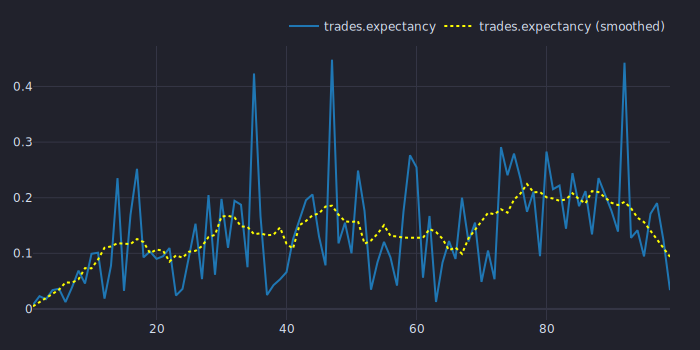

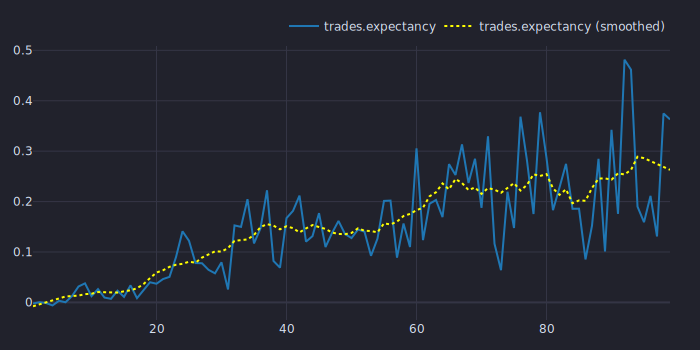

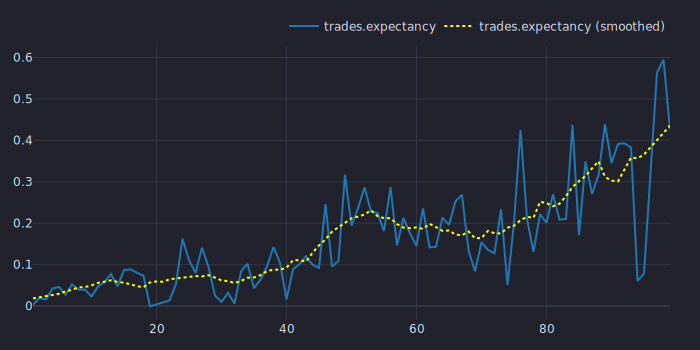

In [25]:
def plot_metric_by_stop(stop_name, metric_name, stat_name, smooth):
    from scipy.signal import savgol_filter

    values = pf.deep_getattr(metric_name)
    values = values.vbt.select_levels(stop_name)
    values = getattr(values.groupby(values.index), stat_name)()
    smooth_values = savgol_filter(values, smooth, 1)
    smooth_values = values.vbt.wrapper.wrap(smooth_values)
    fig = values.rename(metric_name).vbt.plot()
    smooth_values.rename(f"{metric_name} (smoothed)").vbt.plot(
        trace_kwargs=dict(line=dict(dash="dot", color="yellow")),
        fig=fig, 
    )
    return fig

plot_metric_by_stop(
    "sl_stop", 
    "trades.expectancy", 
    "median",
    10
).show_svg()
plot_metric_by_stop(
    "tsl_stop", 
    "trades.expectancy", 
    "median",
    10
).show_svg()
plot_metric_by_stop(
    "tp_stop", 
    "trades.expectancy", 
    "median",
    10
).show_svg()

### Level: Engineer

In [26]:
@njit(nogil=True)
def pt_signals_nb(close, window=WINDOW, upper=UPPER, lower=LOWER):
    x = np.expand_dims(close[:, 0], 1)
    y = np.expand_dims(close[:, 1], 1)
    _, _, zscore = vbt.ind_nb.ols_nb(x, y, window)
    zscore_1d = zscore[:, 0]
    upper_ts = np.full_like(zscore_1d, upper, dtype=np.float_)
    lower_ts = np.full_like(zscore_1d, lower, dtype=np.float_)
    upper_crossed = vbt.nb.crossed_above_1d_nb(zscore_1d, upper_ts)
    lower_crossed = vbt.nb.crossed_above_1d_nb(lower_ts, zscore_1d)
    long_entries = np.full_like(close, False, dtype=np.bool_)
    short_entries = np.full_like(close, False, dtype=np.bool_)
    short_entries[upper_crossed, 0] = True
    long_entries[upper_crossed, 1] = True
    long_entries[lower_crossed, 0] = True
    short_entries[lower_crossed, 1] = True
    return long_entries, short_entries

In [27]:
long_entries, short_entries = pt_signals_nb(data.close.values)
long_entries = data.symbol_wrapper.wrap(long_entries)
short_entries = data.symbol_wrapper.wrap(short_entries)

print(long_entries.sum())
print(short_entries.sum())

symbol
ALGOUSDT    52
QTUMUSDT    73
dtype: int64
symbol
ALGOUSDT    73
QTUMUSDT    52
dtype: int64


In [28]:
@njit(nogil=True)
def pt_portfolio_nb(
    open, 
    high, 
    low, 
    close,
    long_entries,
    short_entries,
    sl_stop=np.nan,
    tsl_stop=np.nan,
    tp_stop=np.nan,
):
    target_shape = close.shape
    group_lens = np.array([2])
    sim_out = vbt.pf_nb.from_signals_nb(
        target_shape=target_shape,
        group_lens=group_lens,
        auto_call_seq=True,
        open=open,
        high=high,
        low=low,
        close=close,
        long_entries=long_entries,
        short_entries=short_entries,
        size=10,
        size_type=vbt.pf_enums.SizeType.ValuePercent100,
        sl_stop=sl_stop,
        tsl_stop=tsl_stop,
        tp_stop=tp_stop,
        delta_format=vbt.pf_enums.DeltaFormat.Percent100,
        stop_exit_price=vbt.pf_enums.StopExitPrice.Close
    )
    return sim_out

In [29]:
sim_out = pt_portfolio_nb(
    data.open.values,
    data.high.values,
    data.low.values,
    data.close.values,
    long_entries.values,
    short_entries.values
)

In [30]:
pf = vbt.Portfolio(
    data.symbol_wrapper.regroup(group_by=True),
    sim_out,
    open=data.open,
    high=data.high,
    low=data.low,
    close=data.close,
    cash_sharing=True,
    init_cash=100
)

print(pf.total_return)

0.19930328736504038


In [31]:
@njit(nogil=True)
def pt_metrics_nb(close, sim_out):
    target_shape = close.shape
    group_lens = np.array([2])
    filled_close = vbt.nb.fbfill_nb(close)
    col_map = vbt.rec_nb.col_map_nb(
        col_arr=sim_out.order_records["col"], 
        n_cols=target_shape[1]
    )
    total_profit = vbt.pf_nb.total_profit_nb(
        target_shape=target_shape,
        close=filled_close,
        order_records=sim_out.order_records,
        col_map=col_map
    )
    total_profit_grouped = vbt.pf_nb.total_profit_grouped_nb(
        total_profit=total_profit,
        group_lens=group_lens,
    )[0]
    total_return = total_profit_grouped / 100
    trade_records = vbt.pf_nb.get_exit_trades_nb(
        order_records=sim_out.order_records, 
        close=filled_close, 
        col_map=col_map
    )
    trade_records = trade_records[
        trade_records["status"] == vbt.pf_enums.TradeStatus.Closed
    ]
    expectancy = vbt.pf_nb.expectancy_reduce_nb(
        pnl_arr=trade_records["pnl"]
    )
    return total_return, expectancy

In [32]:
pt_metrics_nb(data.close.values, sim_out)

(0.19930328736504038, 0.7135952049405152)

In [33]:
@njit(nogil=True)
def pt_pipeline_nb(
    open, 
    high, 
    low, 
    close,
    window=WINDOW,
    upper=UPPER,
    lower=LOWER,
    sl_stop=np.nan,
    tsl_stop=np.nan,
    tp_stop=np.nan,
):
    long_entries, short_entries = pt_signals_nb(
        close, 
        window=window, 
        upper=upper, 
        lower=lower
    )
    sim_out = pt_portfolio_nb(
        open,
        high,
        low,
        close,
        long_entries,
        short_entries,
        sl_stop=sl_stop,
        tsl_stop=tsl_stop,
        tp_stop=tp_stop
    )
    return pt_metrics_nb(close, sim_out)

In [34]:
pt_pipeline_nb(
    data.open.values,
    data.high.values,
    data.low.values,
    data.close.values
)

(0.19930328736504038, 0.7135952049405152)

In [35]:
%%timeit
pt_pipeline_nb(
    data.open.values,
    data.high.values,
    data.low.values,
    data.close.values
)

5.36 ms ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
param_pt_pipeline = vbt.parameterized(
    pt_pipeline_nb, 
    merge_func="concat",
    seed=42,
    engine="threadpool",
    chunk_len="auto"
)

In [37]:
UPPER_SPACE = [st.norm.ppf(1 - x / 2) for x in ALPHA_SPACE]
LOWER_SPACE = [-st.norm.ppf(1 - x / 2) for x in ALPHA_SPACE]
POPT_FILE = "temp/param_opt.pickle"

# vbt.remove_file(POPT_FILE, missing_ok=True)
if not vbt.file_exists(POPT_FILE):
    param_opt = param_pt_pipeline(
        data.open.values,
        data.high.values,
        data.low.values,
        data.close.values,
        window=vbt.Param(WINDOW_SPACE),
        upper=vbt.Param(UPPER_SPACE),
        lower=vbt.Param(LOWER_SPACE)
    )
    vbt.save(param_opt, POPT_FILE)
else:
    param_opt = vbt.load(POPT_FILE)

total_return, expectancy = param_opt

In [38]:
print(total_return)

window  upper     lower    
5       3.290527  -3.290527    0.000000
                  -3.090232    0.000000
                  -2.967738    0.000000
                  -2.878162    0.000000
                  -2.807034    0.000000
                                 ...   
49      1.649721  -1.669593    0.196197
                  -1.664563    0.192152
                  -1.659575    0.190713
                  -1.654628    0.201239
                  -1.649721    0.204764
Length: 441045, dtype: float64


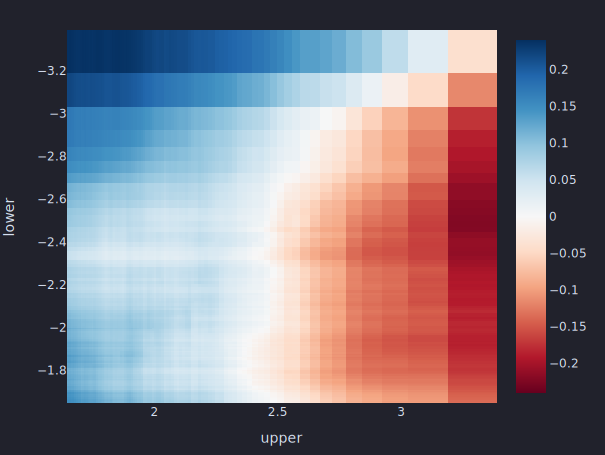

In [39]:
grouped_metric = total_return.groupby(level=["upper", "lower"]).mean()
grouped_metric.vbt.heatmap(
    trace_kwargs=dict(colorscale="RdBu", zmid=0),
    yaxis=dict(autorange="reversed")
).show_svg()

In [40]:
@njit(nogil=True)
def pt_pipeline_mult_nb(
    n_params: int,
    open:     tp.Array2d, 
    high:     tp.Array2d, 
    low:      tp.Array2d, 
    close:    tp.Array2d,
    window:   tp.FlexArray1dLike = WINDOW,
    upper:    tp.FlexArray1dLike = UPPER,
    lower:    tp.FlexArray1dLike = LOWER,
    sl_stop:  tp.FlexArray1dLike = np.nan,
    tsl_stop: tp.FlexArray1dLike = np.nan,
    tp_stop:  tp.FlexArray1dLike = np.nan,
):
    window_ = vbt.to_1d_array_nb(np.asarray(window))
    upper_ = vbt.to_1d_array_nb(np.asarray(upper))
    lower_ = vbt.to_1d_array_nb(np.asarray(lower))
    sl_stop_ = vbt.to_1d_array_nb(np.asarray(sl_stop))
    tsl_stop_ = vbt.to_1d_array_nb(np.asarray(tsl_stop))
    tp_stop_ = vbt.to_1d_array_nb(np.asarray(tp_stop))

    total_return = np.empty(n_params, dtype=np.float_)
    expectancy = np.empty(n_params, dtype=np.float_)

    for i in range(n_params):
        total_return[i], expectancy[i] = pt_pipeline_nb(
            open,
            high,
            low,
            close,
            window=vbt.flex_select_1d_nb(window_, i),
            upper=vbt.flex_select_1d_nb(upper_, i),
            lower=vbt.flex_select_1d_nb(lower_, i),
            sl_stop=vbt.flex_select_1d_nb(sl_stop_, i),
            tsl_stop=vbt.flex_select_1d_nb(tsl_stop_, i),
            tp_stop=vbt.flex_select_1d_nb(tp_stop_, i),
        )
    return total_return, expectancy

In [41]:
pt_pipeline_mult_nb(
    3,
    data.open.values,
    data.high.values,
    data.low.values,
    data.close.values,
    window=np.array([10, 20, 30])
)

(array([ 0.11131525, -0.04819178,  0.13124959]),
 array([ 0.01039436, -0.00483853,  0.01756337]))

In [42]:
chunked_pt_pipeline = vbt.chunked(
    pt_pipeline_mult_nb,
    size=vbt.ArgSizer(arg_query="n_params"),
    arg_take_spec=dict(
        n_params=vbt.CountAdapter(),
        open=None,
        high=None,
        low=None,
        close=None,
        window=vbt.FlexArraySlicer(),
        upper=vbt.FlexArraySlicer(),
        lower=vbt.FlexArraySlicer(),
        sl_stop=vbt.FlexArraySlicer(),
        tsl_stop=vbt.FlexArraySlicer(),
        tp_stop=vbt.FlexArraySlicer()
    ),
    chunk_len=1000,
    merge_func="concat",
    execute_kwargs=dict(
        chunk_len="auto",
        engine="threadpool",
    )
)

In [43]:
param_product, param_index = vbt.combine_params(
    dict(
        window=vbt.Param(WINDOW_SPACE),
        upper=vbt.Param(UPPER_SPACE),
        lower=vbt.Param(LOWER_SPACE)
    )
)

In [44]:
COPT_FILE = "temp/chunked_opt.pickle"

# vbt.remove_file(COPT_FILE, missing_ok=True)
if not vbt.file_exists(COPT_FILE):
    chunked_opt = chunked_pt_pipeline(
        len(param_index),
        data.open.values,
        data.high.values,
        data.low.values,
        data.close.values,
        window=param_product["window"],
        upper=param_product["upper"],
        lower=param_product["lower"]
    )
    vbt.save(chunked_opt, COPT_FILE)
else:
    chunked_opt = vbt.load(COPT_FILE)

total_return, expectancy = chunked_opt

In [45]:
total_return = pd.Series(total_return, index=param_index)
expectancy = pd.Series(expectancy, index=param_index)

In [46]:
GRID_LEN = len(WINDOW_SPACE) * \
    len(UPPER_SPACE) * \
    len(LOWER_SPACE) * \
    len(STOP_SPACE) ** 3
print(GRID_LEN)

441045000000


In [48]:
GRID = dict(
    window=WINDOW_SPACE,
    upper=UPPER_SPACE,
    lower=LOWER_SPACE,
    sl_stop=STOP_SPACE,
    tsl_stop=STOP_SPACE,
    tp_stop=STOP_SPACE,
)
vbt.pprint(vbt.pick_from_param_grid(GRID, 123_456_789))

dict(
    window=5,
    upper=3.090232306167813,
    lower=-2.241402727604947,
    sl_stop=45,
    tsl_stop=67,
    tp_stop=89
)


In [49]:
FOUND_FILE = "temp/found.pickle"
BEST_N = 100
BEST_TH = 1.0
CHUNK_LEN = 10_000

# vbt.remove_file(FOUND_FILE, missing_ok=True)
if vbt.file_exists(FOUND_FILE):
    found = vbt.load(FOUND_FILE)
else:
    found = None
with (
    vbt.ProgressBar(
        desc="Found", 
        initial=0 if found is None else len(found),
        total=BEST_N
    ) as pbar1,
    vbt.ProgressBar(
        desc="Processed"
    ) as pbar2
):
    while found is None or len(found) < BEST_N:
        param_df = pd.DataFrame([
            vbt.pick_from_param_grid(GRID) 
            for _ in range(CHUNK_LEN)
        ])
        param_index = pd.MultiIndex.from_frame(param_df)
        _, expectancy = chunked_pt_pipeline(
            CHUNK_LEN,
            data.open.values,
            data.high.values,
            data.low.values,
            data.close.values,
            window=param_df["window"],
            upper=param_df["upper"],
            lower=param_df["lower"],
            sl_stop=param_df["sl_stop"],
            tsl_stop=param_df["tsl_stop"],
            tp_stop=param_df["tp_stop"],
            _chunk_len=None,
            _execute_kwargs=dict(
                chunk_len=None
            )
        )
        expectancy = pd.Series(expectancy, index=param_index)
        best_mask = expectancy >= BEST_TH
        if best_mask.any():
            best = expectancy[best_mask]
            if found is None:
                found = best
            else:
                found = pd.concat((found, best))
                found = found[~found.index.duplicated(keep="first")]
            vbt.save(found, FOUND_FILE)
            pbar1.update_to(len(found))
            pbar1.refresh()
        pbar2.update(len(expectancy))

Found: 105it [00:00, ?it/s]

Processed: 0it [00:00, ?it/s]

In [50]:
def get_param_median(param):
    return found.index.get_level_values(param).to_series().median()

pt_pipeline_nb(
    data.open.values, 
    data.high.values, 
    data.low.values, 
    data.close.values,
    window=int(get_param_median("window")),
    upper=get_param_median("upper"),
    lower=get_param_median("lower"),
    sl_stop=get_param_median("sl_stop"),
    tsl_stop=get_param_median("tsl_stop"),
    tp_stop=get_param_median("tp_stop")
)

(0.2324893819900153, 1.7712394377565626)

In [51]:
import optuna

optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    window = trial.suggest_categorical("window", WINDOW_SPACE)
    upper = trial.suggest_categorical("upper", UPPER_SPACE)
    lower = trial.suggest_categorical("lower", LOWER_SPACE)
    sl_stop = trial.suggest_categorical("sl_stop", STOP_SPACE)
    tsl_stop = trial.suggest_categorical("tsl_stop", STOP_SPACE)
    tp_stop = trial.suggest_categorical("tp_stop", STOP_SPACE)
    total_return, expectancy = pt_pipeline_nb(
        data.open.values,
        data.high.values,
        data.low.values,
        data.close.values,
        window=window,
        upper=upper,
        lower=lower,
        sl_stop=sl_stop,
        tsl_stop=tsl_stop,
        tp_stop=tp_stop
    )
    if np.isnan(total_return):
        raise optuna.TrialPruned()
    if np.isnan(expectancy):
        raise optuna.TrialPruned()
    return total_return, expectancy

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=1000)

trials_df = study.trials_dataframe(attrs=["params", "values"])
trials_df.set_index([
    "params_window", 
    "params_upper", 
    "params_lower",
    "params_sl_stop",
    "params_tsl_stop",
    "params_tp_stop"
], inplace=True)
trials_df.index.rename([
    "window", 
    "upper", 
    "lower",
    "sl_stop",
    "tsl_stop",
    "tp_stop"
], inplace=True)
trials_df.columns = ["total_return", "expectancy"]
trials_df = trials_df[~trials_df.index.duplicated(keep="first")]
print(trials_df.sort_values(by="total_return", ascending=False))

                                                    total_return  expectancy
window upper    lower     sl_stop tsl_stop tp_stop                          
6      1.926837 -1.959964 37.0    53.0     44.0         0.685458    0.104482
                -1.888193 87.0    65.0     44.0         0.669679    0.085328
                          37.0    65.0     44.0         0.667077    0.084662
                          34.0    65.0     44.0         0.659116    0.083531
       1.684941 -1.888193 57.0    69.0     72.0         0.604595    0.053457
...                                                          ...         ...
       2.307984 -2.878162 37.0    68.0     44.0              NaN         NaN
5      2.512144 -2.053749 87.0    87.0     98.0              NaN         NaN
       2.053749 -2.053749 87.0    87.0     88.0              NaN         NaN
       2.211518 -2.326348 87.0    53.0     44.0              NaN         NaN
       2.170090 -2.967738 55.0    3.0      88.0              NaN         NaN

### Level: Architect

In [52]:
InOutputs = namedtuple("InOutputs", ["spread", "zscore"])

@njit(nogil=True, boundscheck=True)
def can_execute_nb(c, wait_days):
    if c.order_counts[c.col] == 0:
        return True
    last_order = c.order_records[c.order_counts[c.col] - 1, c.col]
    ns_delta = c.index[c.i] - c.index[last_order.idx]
    if ns_delta >= wait_days * vbt.dt_nb.d_ns:
        return True
    return False

@njit(nogil=True, boundscheck=True)
def create_signals_nb(c, upper, lower, wait_days):
    _upper = vbt.pf_nb.select_nb(c, upper)
    _lower = vbt.pf_nb.select_nb(c, lower)
    _wait_days = vbt.pf_nb.select_nb(c, wait_days)

    if c.i > 0:
        prev_zscore = c.in_outputs.zscore[c.i - 1, c.group]
        zscore = c.in_outputs.zscore[c.i, c.group]
        if prev_zscore < _upper and zscore > _upper:
            if can_execute_nb(c, _wait_days):
                if c.col % 2 == 0:
                    return False, False, True, False
                return True, False, False, False
        if prev_zscore > _lower and zscore < _lower:
            if can_execute_nb(c, _wait_days):
                if c.col % 2 == 0:
                    return True, False, False, False
                return False, False, True, False
    return False, False, False, False

@njit(nogil=True, boundscheck=True)
def signal_func_nb(c, window, upper, lower, wait_days):
    _window = vbt.pf_nb.select_nb(c, window)
        
    if c.col % 2 == 0:
        x = vbt.pf_nb.select_nb(c, c.close, col=c.col)
        y = vbt.pf_nb.select_nb(c, c.close, col=c.col + 1)
        c.in_outputs.spread[c.i, c.group] = np.log(y) - np.log(x)
        
        window_start = c.i - _window + 1
        window_end = c.i + 1
        if window_start >= 0:
            s = c.in_outputs.spread[window_start : window_end, c.group]
            s_mean = np.nanmean(s)
            s_std = np.nanstd(s)
            c.in_outputs.zscore[c.i, c.group] = (s[-1] - s_mean) / s_std
    return create_signals_nb(c, upper, lower, wait_days)

In [53]:
WAIT_DAYS = 30

def iter_pt_portfolio(
    window=WINDOW, 
    upper=UPPER, 
    lower=LOWER, 
    wait_days=WAIT_DAYS,
    signal_func_nb=signal_func_nb,
    more_signal_args=(),
    **kwargs
):
    return vbt.Portfolio.from_signals(
        data,
        broadcast_named_args=dict(
            window=window,
            upper=upper,
            lower=lower,
            wait_days=wait_days
        ),
        in_outputs=vbt.RepEval("""
            InOutputs(
                np.full((target_shape[0], target_shape[1] // 2), np.nan), 
                np.full((target_shape[0], target_shape[1] // 2), np.nan)
            )
        """, context=dict(InOutputs=InOutputs)),
        signal_func_nb=signal_func_nb,
        signal_args=(
            vbt.Rep("window"),
            vbt.Rep("upper"),
            vbt.Rep("lower"),
            vbt.Rep("wait_days"),
            *more_signal_args
        ),
        size=10,
        size_type="valuepercent100",
        group_by=vbt.ExceptLevel("symbol"),
        cash_sharing=True,
        call_seq="auto",
        delta_format="percent100",
        stop_exit_price="close",
        **kwargs
    )

In [54]:
pf = iter_pt_portfolio()

In [55]:
fig = vbt.make_subplots(
    rows=2, 
    cols=1, 
    vertical_spacing=0,
    shared_xaxes=True
)
zscore = pf.get_in_output("zscore").rename("Z-score")
zscore.vbt.plot(
    add_trace_kwargs=dict(row=1, col=1),
    fig=fig
)
fig.add_hline(row=1, y=UPPER, line_color="orangered", line_dash="dot")
fig.add_hline(row=1, y=0, line_color="yellow", line_dash="dot")
fig.add_hline(row=1, y=LOWER, line_color="limegreen", line_dash="dot")
orders = pf.orders.regroup(group_by=False).iloc[:, 0]
exit_mask = orders.side_sell.get_pd_mask(idx_arr="signal_idx")
entry_mask = orders.side_buy.get_pd_mask(idx_arr="signal_idx")
upper_crossed = zscore.vbt.crossed_above(UPPER)
lower_crossed = zscore.vbt.crossed_below(LOWER)
(upper_crossed & ~exit_mask).vbt.signals.plot_as_exits(
    pf.get_in_output("zscore"),
    trace_kwargs=dict(
        name="Exits (ignored)", 
        marker=dict(color="lightgray"), 
        opacity=0.5
    ),
    add_trace_kwargs=dict(row=1, col=1),
    fig=fig
)
(lower_crossed & ~entry_mask).vbt.signals.plot_as_entries(
    pf.get_in_output("zscore"),
    trace_kwargs=dict(
        name="Entries (ignored)", 
        marker=dict(color="lightgray"), 
        opacity=0.5
    ),
    add_trace_kwargs=dict(row=1, col=1),
    fig=fig
)
exit_mask.vbt.signals.plot_as_exits(
    pf.get_in_output("zscore"),
    add_trace_kwargs=dict(row=1, col=1),
    fig=fig
)
entry_mask.vbt.signals.plot_as_entries(
    pf.get_in_output("zscore"),
    add_trace_kwargs=dict(row=1, col=1),
    fig=fig
)
pf.plot_allocations(
    add_trace_kwargs=dict(row=2, col=1),
    fig=fig
)
rebalancing_dates = data.index[np.unique(orders.idx.values)]
for date in rebalancing_dates:
    fig.add_vline(row=2, x=date, line_color="teal", line_dash="dot")
fig.update_layout(height=600)
fig.show_svg()

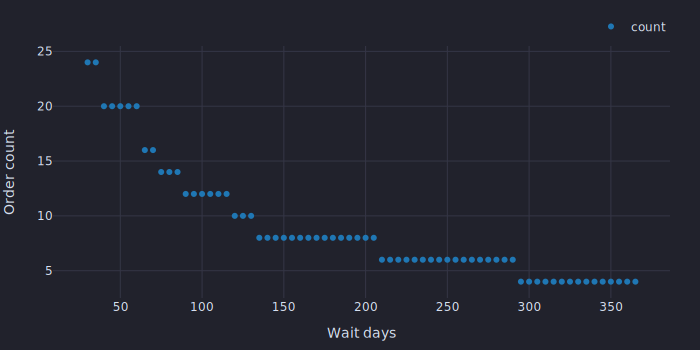

In [56]:
WAIT_SPACE = np.arange(30, 370, 5).tolist()

pf = iter_pt_portfolio(wait_days=vbt.Param(WAIT_SPACE))
pf.orders.count().vbt.scatterplot(
    xaxis_title="Wait days",
    yaxis_title="Order count"
).show_svg()

In [57]:
with (vbt.Timer() as timer, vbt.MemTracer() as tracer):
    iter_pt_portfolio(wait_days=vbt.Param(WAIT_SPACE))
print(timer.elapsed())
print(tracer.peak_usage())

7.05 seconds
306.2 MB


In [58]:
zscore_state_dt = np.dtype(
    [
        ("cumsum", np.float_),
        ("cumsum_sq", np.float_),
        ("nancnt", np.int_)
    ],
    align=True,
)

@njit(nogil=True, boundscheck=True)
def stream_signal_func_nb(
    c, 
    window, 
    upper, 
    lower, 
    wait_days, 
    zscore_state
):
    _window = vbt.pf_nb.select_nb(c, window)
        
    if c.col % 2 == 0:
        x = vbt.pf_nb.select_nb(c, c.close, col=c.col)
        y = vbt.pf_nb.select_nb(c, c.close, col=c.col + 1)
        c.in_outputs.spread[c.i, c.group] = np.log(y) - np.log(x)
        
        value = c.in_outputs.spread[c.i, c.group]
        pre_i = c.i - _window
        if pre_i >= 0:
            pre_window_value = c.in_outputs.spread[pre_i, c.group]
        else:
            pre_window_value = np.nan
        zscore_in_state = vbt.enums.RollZScoreAIS(
            i=c.i,
            value=value,
            pre_window_value=pre_window_value,
            cumsum=zscore_state["cumsum"][c.group],
            cumsum_sq=zscore_state["cumsum_sq"][c.group],
            nancnt=zscore_state["nancnt"][c.group],
            window=_window,
            minp=_window,
            ddof=0
        )
        zscore_out_state = vbt.nb.rolling_zscore_acc_nb(zscore_in_state)
        c.in_outputs.zscore[c.i, c.group] = zscore_out_state.value
        zscore_state["cumsum"][c.group] = zscore_out_state.cumsum
        zscore_state["cumsum_sq"][c.group] = zscore_out_state.cumsum_sq
        zscore_state["nancnt"][c.group] = zscore_out_state.nancnt
        
    return create_signals_nb(c, upper, lower, wait_days)

In [59]:
from functools import partial

stream_pt_portfolio = partial(
    iter_pt_portfolio,
    signal_func_nb=stream_signal_func_nb,
    more_signal_args=(
        vbt.RepEval(
            """
            zscore_state = np.empty(target_shape[1] // 2, dtype=zscore_state_dt)
            zscore_state["cumsum"] = 0.0
            zscore_state["cumsum_sq"] = 0.0
            zscore_state["nancnt"] = 0
            zscore_state
            """, 
            context=dict(zscore_state_dt=zscore_state_dt)
        ),
    )
)

In [60]:
stream_pf = stream_pt_portfolio()
print(stream_pf.total_return)

pf = iter_pt_portfolio()
print(pf.total_return)

0.15210165047643728
0.15210165047643728


In [61]:
stream_pt_portfolio(wait_days=vbt.Param(WAIT_SPACE))  # compilation
with (vbt.Timer() as timer, vbt.MemTracer() as tracer):
    stream_pt_portfolio(wait_days=vbt.Param(WAIT_SPACE))
print(timer.elapsed())
print(tracer.peak_usage())

1.49 seconds
306.2 MB


In [62]:
chunked_stream_pt_portfolio = partial(
    stream_pt_portfolio,
    chunked=dict(
        engine="threadpool",
        arg_take_spec=dict(
            signal_args=vbt.ArgsTaker(
                vbt.flex_array_gl_slicer,
                vbt.flex_array_gl_slicer,
                vbt.flex_array_gl_slicer,
                vbt.flex_array_gl_slicer,
                vbt.ArraySlicer(axis=0)
            ),
            in_outputs=vbt.SequenceTaker([
                vbt.ArraySlicer(axis=1),
                vbt.ArraySlicer(axis=1)
            ])
        )
    )
)

In [63]:
chunked_stream_pt_portfolio(wait_days=vbt.Param(WAIT_SPACE))  # compilation
with (vbt.Timer() as timer, vbt.MemTracer() as tracer):
    chunked_stream_pt_portfolio(wait_days=vbt.Param(WAIT_SPACE))

print(timer.elapsed())
print(tracer.peak_usage())

536.82 milliseconds
306.4 MB
